In [280]:
#Importing the neccessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [281]:
#Reading loan.csv file
loan_data = pd.read_csv('loan.csv')

In [282]:
#Printing the shape of the dataFrame and Printing the datatypes of the data Frame
print(loan_data.shape)
print('------------------------')
print(loan_data.info())
print('------------------------')
print(loan_data.dtypes)

(39717, 111)
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None
------------------------
id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object


# Handling Missing Values and Data Cleaning

### Data Cleaning Steps
<b> 1.Normalization:</b> <br>Key variables such as Debt-to-Income Ratio (DTI) and Loan Amount were normalized to align scales and improve comparability.<br>
<b> 2.Percentage Conversion:</b> <br>Converted percentage strings (e.g., Interest Rate) to numerical values for accurate calculations and comparisons.<br>
<b> 3.Imputation of Missing Values: </b> <br>Missing values, particularly in numerical columns, were imputed using median values to maintain data integrity.<br>
<b> 4.One-Hot Encoding: </b> <br> Categorical variables like 'home_ownership', 'term', and 'grade' were one-hot encoded to transform them into a format suitable for modeling.<br>
<b> 5.Derived Metrics Creation: </b><br> Developed new metrics such as 'credit_score', 'loan_utilization_rate', and 'payment-to-income ratio (pti)' for deeper analysis.<br>


In [387]:
#Imputed N/A values with median values in annual_inc,loan_amnt,int_rate columns
loan_data['annual_inc'] = loan_data['annual_inc'].fillna(loan_data['annual_inc'].median())
loan_data['loan_amnt'] = loan_data['loan_amnt'].fillna(loan_data['loan_amnt'].median())
loan_data['int_rate'] = loan_data['int_rate'].fillna(loan_data['int_rate'].median())
loan_data['dti'] = loan_data['dti'].fillna(loan_data['dti'].median())
#Imputed N/A values with UNKNOWN text in grade,term columns
loan_data['grade'] = loan_data['grade'].fillna("Unknown")
loan_data['term'] = loan_data['term'].fillna("Unknown")
loan_data['emp_length'] = loan_data.emp_length.astype('str').str.extract('(\d+)')
loan_data['int_rate'] = loan_data['int_rate'].astype('str').str.rstrip('%').astype('float')
loan_data['term'] = loan_data['term'].astype('str').str.extract('(\d+)').astype('float')

In [385]:
#Converting emp_length column to numbers. As it might be helpful in future analysis
#Filling the N/A values with 0 
loan_data.emp_length.fillna('0',inplace=True)
#Extracting the text out of the columns like 'years' or '>' or '<'
loan_data['emp_length']=loan_data.emp_length.astype('str').str.extract('(\d+)')
loan_data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,normalized_loan_amnt,credit_score,loan_utilization_rate,year,month,loan_amnt_buckets,annual_inc_buckets,int_buckets,dti_buckets,approval_percentage
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,...,0.130435,31.548777,100.0,2011,12,0-7000,0-50000,10%-15%,25+,99.5
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,...,0.057971,95.926758,100.0,2011,12,0-7000,0-50000,15%-20%,0-5,100.0


<Axes: ylabel='annual_inc'>

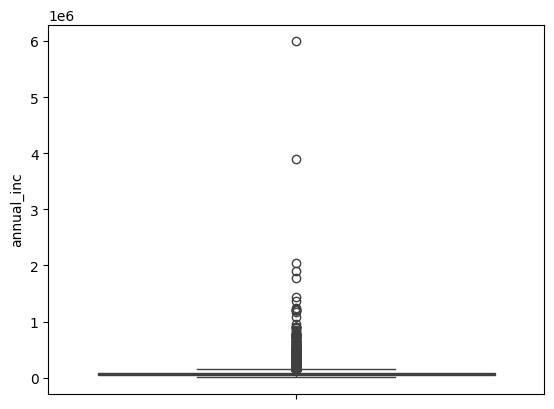

In [286]:
sns.boxplot(data=loan_data.annual_inc)

### Observation: In the above result, we can see there are more number of Outliers, so we need to be remove those to make the data more sensible.

In [287]:
#To remove outliers we have replaced the outliers values with the 99% quantile value 
cap_value = loan_data['annual_inc'].quantile(0.99)
loan_data['annual_inc'] = np.where(loan_data['annual_inc'] > cap_value, cap_value, loan_data['annual_inc'])

<Axes: ylabel='annual_inc'>

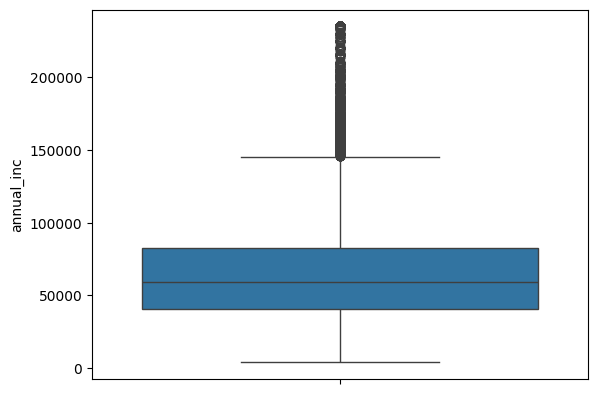

In [288]:
#Again using the 
sns.boxplot(data=loan_data.annual_inc)

### Identifying the columns with the 100% NULL Values

In [289]:
null_value_columns_100perc=loan_data.columns[loan_data.isnull().mean()*100==100]

In [290]:
null_columns=round(len(loan_data.columns[loan_data.isnull().mean()*100==100])/loan_data.shape[1]*100,0)
null_columns

49.0

### Observation: Nearly 49% of columns has NULL data, So we need to remove them

In [291]:
#Removing the null columns with 100% columns
loan_data=loan_data.drop(null_value_columns_100perc,axis=1)

In [292]:
round(loan_data.isna().mean()*100,0)

id                             0.0
member_id                      0.0
loan_amnt                      0.0
funded_amnt                    0.0
funded_amnt_inv                0.0
term                           0.0
int_rate                       0.0
installment                    0.0
grade                          0.0
sub_grade                      0.0
emp_title                      6.0
emp_length                     0.0
home_ownership                 0.0
annual_inc                     0.0
verification_status            0.0
issue_d                        0.0
loan_status                    0.0
pymnt_plan                     0.0
url                            0.0
desc                          33.0
purpose                        0.0
title                          0.0
zip_code                       0.0
addr_state                     0.0
dti                            0.0
delinq_2yrs                    0.0
earliest_cr_line               0.0
inq_last_6mths                 0.0
mths_since_last_deli

In [293]:
null_value_columns_perc50=loan_data.columns[loan_data.isnull().mean()*100>=50]

In [294]:
null_value_columns_perc50

Index(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'], dtype='object')

### Removing the columns which has 50% NULL values

In [295]:
loan_data =loan_data.drop(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'],axis=1)

### Dropping Unused Columns

In [296]:
loan_data.drop(['url','title','zip_code','delinq_2yrs','earliest_cr_line','inq_last_6mths'],axis=1,inplace=True)

In [297]:
loan_data.drop(['out_prncp_inv','total_rec_prncp','total_rec_late_fee','recoveries','collection_recovery_fee','collections_12_mths_ex_med','delinq_amnt','tax_liens'],axis=1,inplace=True)

In [298]:
loan_data.drop(['open_acc','pub_rec','total_acc','initial_list_status','out_prncp','desc','emp_title'],axis=1,inplace=True)

In [299]:
loan_data.shape

(39717, 33)

In [300]:
round(loan_data.isna().mean()*100,0)

id                          0.0
member_id                   0.0
loan_amnt                   0.0
funded_amnt                 0.0
funded_amnt_inv             0.0
term                        0.0
int_rate                    0.0
installment                 0.0
grade                       0.0
sub_grade                   0.0
emp_length                  0.0
home_ownership              0.0
annual_inc                  0.0
verification_status         0.0
issue_d                     0.0
loan_status                 0.0
pymnt_plan                  0.0
purpose                     0.0
addr_state                  0.0
dti                         0.0
revol_bal                   0.0
revol_util                  0.0
total_pymnt                 0.0
total_pymnt_inv             0.0
total_rec_int               0.0
last_pymnt_d                0.0
last_pymnt_amnt             0.0
last_credit_pull_d          0.0
policy_code                 0.0
application_type            0.0
acc_now_delinq              0.0
chargeof

## Creating Derived columns

In [301]:
# Normalize your chosen variables (example: DTI, loan_amnt)
loan_data['normalized_dti'] = (loan_data['dti'] - loan_data['dti'].min()) / (loan_data['dti'].max() - loan_data['dti'].min())
loan_data['normalized_loan_amnt'] = (loan_data['loan_amnt'] - loan_data['loan_amnt'].min()) / (loan_data['loan_amnt'].max() - loan_data['loan_amnt'].min())

### Credit score calculation
loan_data['credit_score'] = 100 - (loan_data['normalized_dti'] * 0.7 + loan_data['normalized_loan_amnt'] * 0.3) * 100

The formula used to calculate the credit score in your dataset was based on a combination of the normalized Debt-to-Income Ratio (DTI) and normalized Loan Amount, with respective weights of 70% and 30%. This specific formula was likely chosen based on certain assumptions and objective. <br>
1.	Debt-to-Income Ratio (DTI) Weight: The DTI ratio is a crucial indicator in credit scoring. It measures a borrower's monthly debt payments relative to their income. A higher DTI ratio suggests a higher burden of debt relative to income, which could indicate a higher risk of default. Giving it a 70% weight emphasizes its importance in assessing financial stress and repayment ability.<br>
2.	Loan Amount Weight: The size of the loan can also be an important factor in credit risk. Larger loans might represent a higher risk, especially if they constitute a significant portion of the borrower's financial commitments. However, this factor is usually less predictive of default risk than DTI, hence the lower weighting of 30%.<br>
3.	Normalization: Both DTI and Loan Amount are normalized to ensure they are on a similar scale. This standardization is crucial when combining variables that may originally have different ranges and distributions.<br>
4.	100-Scaling: The formula scales the weighted sum to a 100-based scale, which is a common practice in credit scoring. This makes the score more interpretable, with higher scores generally indicating better creditworthiness.<br>
It's important to note that this formula and the weights used are somewhat arbitrary and based on certain assumptions about the relative importance of DTI and Loan Amount<br>


In [302]:
loan_data['credit_score'] = 100 - (loan_data['normalized_dti'] * 0.7 + loan_data['normalized_loan_amnt'] * 0.3) * 100

In [303]:
loan_data['credit_score']

0        31.548777
1        95.926758
2        77.994375
3        45.056903
4        55.952129
           ...    
39712    71.815388
39713    78.105165
39714    90.718500
39715    87.404062
39716    60.558592
Name: credit_score, Length: 39717, dtype: float64

<b>Loan Utilization Rate</b><br>


In [304]:
loan_data['loan_utilization_rate'] = loan_data['funded_amnt'] / loan_data['loan_amnt'] *100

In [305]:
amount_columns = ['loan_amnt','funded_amnt','int_rate','funded_amnt_inv','installment','annual_inc','dti','emp_length','total_pymnt']
loan_data[amount_columns] = loan_data[amount_columns].apply(pd.to_numeric)

In [306]:
loan_data[amount_columns]

,loan_amnt,funded_amnt,int_rate,funded_amnt_inv,installment,annual_inc,dti,emp_length,total_pymnt
0,5000,5000,10.65,4975.0,162.87,24000.0,27.65,10,5863.155187
1,2500,2500,15.27,2500.0,59.83,30000.0,1.00,1,1008.710000
2,2400,2400,15.96,2400.0,84.33,12252.0,8.72,10,3005.666844
3,10000,10000,13.49,10000.0,339.31,49200.0,20.00,10,12231.890000
4,3000,3000,12.69,3000.0,67.79,80000.0,17.94,1,3513.330000
...,...,...,...,...,...,...,...,...,...
39712,2500,2500,8.07,1075.0,78.42,110000.0,11.33,4,2822.969293
39713,8500,8500,10.28,875.0,275.38,18000.0,6.40,3,9913.491822
39714,5000,5000,8.07,1325.0,156.84,100000.0,2.30,1,5272.161128
39715,5000,5000,7.43,650.0,155.38,200000.0,3.72,1,5174.198551


### Deriving two new columns (Year and Month) from issue_d column 

In [307]:
loan_data.issue_d = pd.to_datetime(loan_data.issue_d, format='%b-%y')
loan_data['year']=loan_data['issue_d'].dt.year.astype('str')
loan_data['month']=loan_data['issue_d'].dt.month.astype('str')

# Univariate Analysis

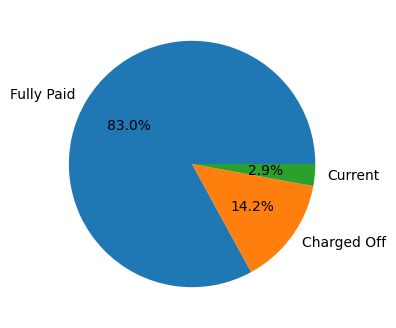

In [380]:
plt.figure(figsize=(4,4))
status=loan_data['loan_status'].value_counts()
plt.pie(status, labels=status.index, autopct='%1.1f%%')
plt.show()

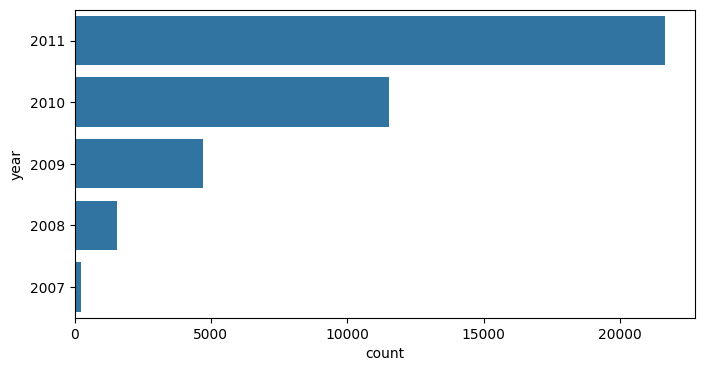

In [308]:
#Ordered Categorical Variable
plt.figure(figsize=(8, 4))
sns.countplot(data=loan_data.year)
plt.show()

### Observation: Number of loan taken is increased year by year

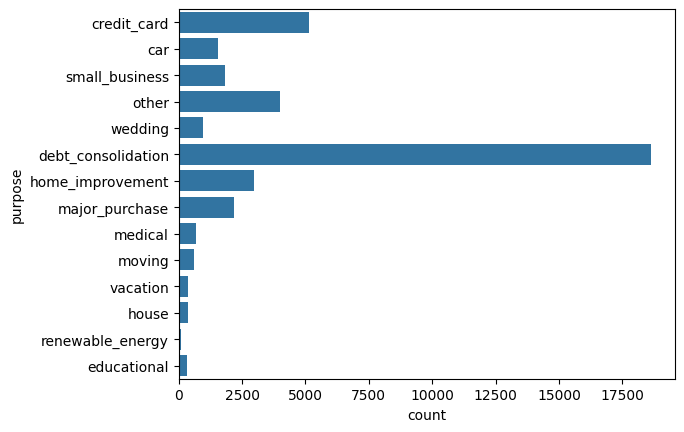

In [309]:
sns.countplot(data=loan_data.purpose)
plt.show()

### Observation: Most of the customers took loan for debt consolidation and credit card payment

In [310]:
#Let's analyse some Quantitive Variable
loan_data['loan_amnt'].describe()

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

<Axes: ylabel='funded_amnt_inv'>

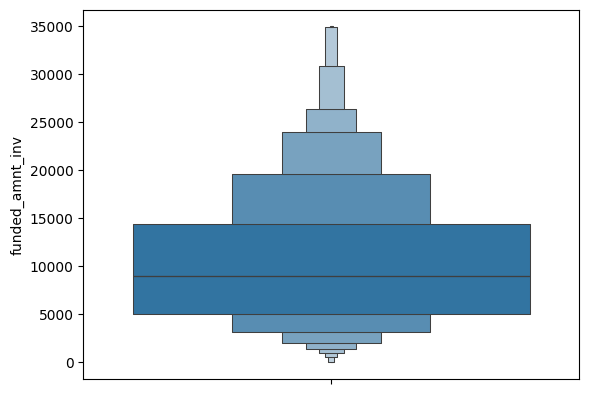

In [311]:
sns.boxenplot(loan_data['funded_amnt_inv'])

<Axes: xlabel='annual_inc', ylabel='Density'>

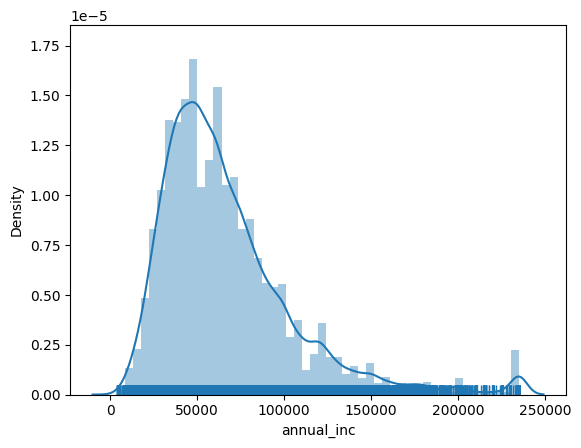

In [312]:
sns.distplot(loan_data['annual_inc'],rug = True)

In [350]:
loan_data['year']=loan_data['year'].astype('int')

<Axes: xlabel='year', ylabel='loan_amnt'>

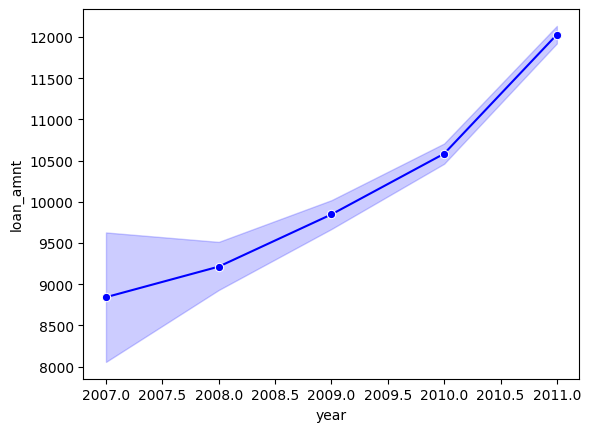

In [351]:
sns.lineplot(x='year', y='loan_amnt', data=loan_data, marker='o', color='b', sort=False)

<Axes: xlabel='annual_inc', ylabel='installment'>

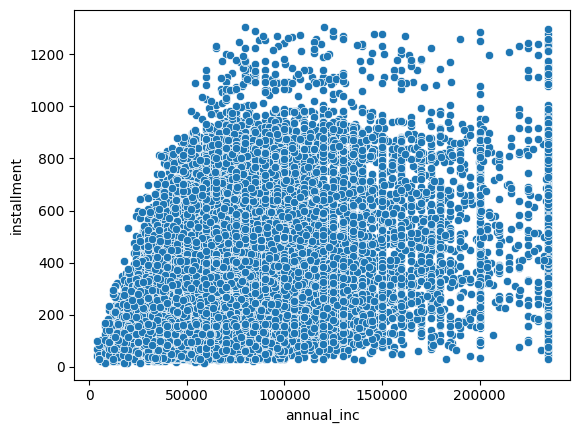

In [367]:
sns.scatterplot(x='annual_inc', y='installment', data=loan_data)

### OBSERVATION: Most of the loan taken is between 5000 to 15000 dollars

In [315]:
#Interest Rate - Another Quantitive variable
loan_data['int_rate'].describe()

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64

### Segmenting by Grade

In [316]:
charged_off_data=loan_data[loan_data['loan_status']=='Charged Off']

<Axes: xlabel='grade', ylabel='count'>

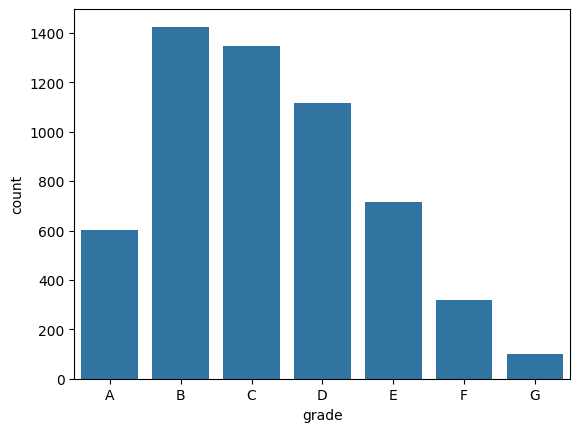

In [317]:
sns.countplot(x='grade',data=charged_off_data,order = loan_data['grade'].sort_values())

### Observation from above statistics is Avg. Interest rate is 12% and Max.interest given upto 25% 

## Deriving new columns by converting Quantitive variable into Categorical varialble for Bivariate Analysis

In [318]:
#Categorize Loan amount into Multiple buckets for deeper analysis
loan_data['loan_amnt_buckets'] = pd.cut(loan_data['loan_amnt'], [0, 7000, 14000, 21000, 28000, 35000], labels=['0-7000', '7000-14000', '14000-21000', '21000-28000', '28000 +'])

In [319]:
#Categorize Annual income into Multiple buckets for deeper analysis
loan_data['annual_inc_buckets'] = pd.cut(loan_data['annual_inc'], [0, 50000, 100000, 150000, 200000,250000], labels=['0-50000', '50000-100000', '100000-150000', '150000-200000', '200000 +'])

In [320]:
#Categorize Interest into Multiple buckets for deeper analysis
loan_data['int_buckets'] = pd.cut(loan_data['int_rate'], [5,10,15,20,25], labels=['5%-10%', '10%-15%', '15%-20%', '20% +'])

In [321]:
#Categorize dti into Multiple buckets for deeper analysis
loan_data['dti_buckets'] = pd.cut(loan_data['dti'], [0, 5, 10, 15, 20, 25, 30], labels=['0-5', '05-10', '10-15', '15-20', '20-25','25+'])

In [322]:
loan_data['approval_percentage']=(loan_data['funded_amnt_inv']/loan_data['funded_amnt'])*100


<Axes: xlabel='annual_inc', ylabel='Count'>

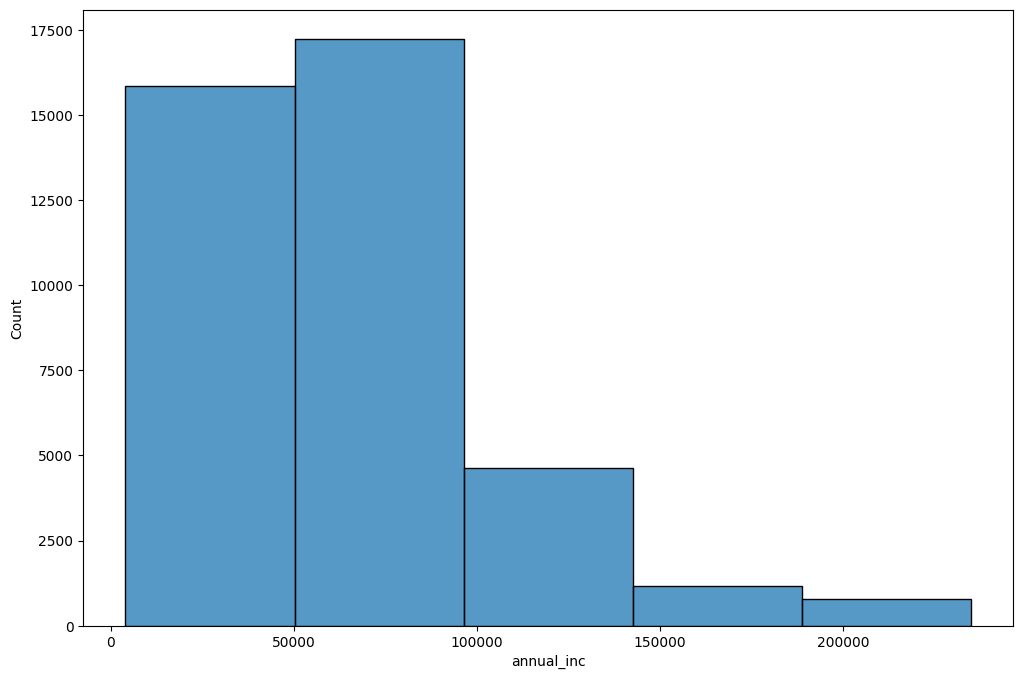

In [323]:
plt.figure(figsize=(12, 8))
sns.histplot(data=loan_data.annual_inc,bins=5)

### Bivariate Analysis between Annual income against  Loan Status - Charged Off

In [324]:
annual_inc_vs_loan_status=pd.pivot_table(loan_data[['annual_inc_buckets','loan_status']],index='annual_inc_buckets',columns='loan_status',aggfunc=len).reset_index()

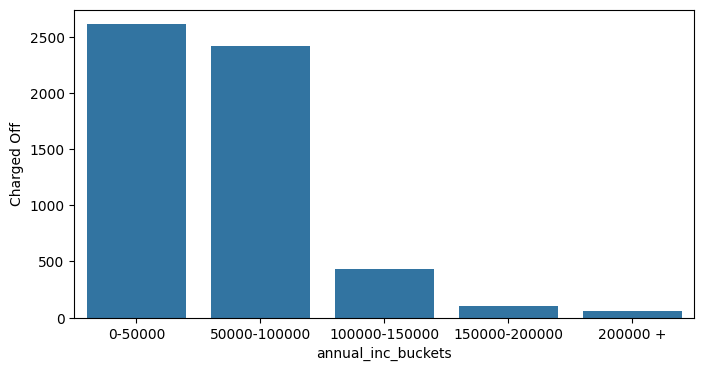

In [325]:
plt.figure(figsize=(8, 4))
sns.barplot(x='annual_inc_buckets', y='Charged Off', data=annual_inc_vs_loan_status)
plt.show()

### Observation: Charged off is getting decreased with increase in Annual Income

In [326]:
int_vs_loan_status=pd.pivot_table(loan_data[['int_buckets','loan_status']],index='int_buckets',columns='loan_status',aggfunc=len).reset_index()

In [327]:
int_vs_loan_status

loan_status,int_buckets,Charged Off,Current,Fully Paid
0,5%-10%,830,77,11486
1,10%-15%,2707,529,15558
2,15%-20%,1794,432,5432
3,20% +,296,102,474


In [328]:
int_vs_loan_status['Total']=int_vs_loan_status['Charged Off']+int_vs_loan_status['Current']+int_vs_loan_status['Fully Paid']
int_vs_loan_status['Charged_off_%']=(int_vs_loan_status['Charged Off']/int_vs_loan_status['Total'])*100

In [329]:
int_vs_loan_status

loan_status,int_buckets,Charged Off,Current,Fully Paid,Total,Charged_off_%
0,5%-10%,830,77,11486,12393,6.697329
1,10%-15%,2707,529,15558,18794,14.403533
2,15%-20%,1794,432,5432,7658,23.426482
3,20% +,296,102,474,872,33.944954


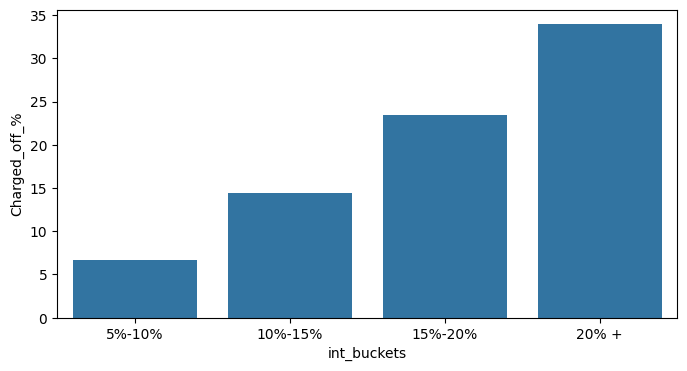

In [330]:
plt.figure(figsize=(8, 4))
sns.barplot(x='int_buckets', y='Charged_off_%', data=int_vs_loan_status)
plt.show()

### Observation: Charged off is getting increased with increase in interest rate. Therefore Loans with lower interest is having less chance of Default

### Bivariate Analysis between Loan amount against Loan Status - Charged Off


In [331]:
loan_amount_vs_loan_status=pd.pivot_table(loan_data[['loan_amnt_buckets','loan_status']],index='loan_amnt_buckets',columns='loan_status',aggfunc=len).reset_index()

In [332]:
loan_amount_vs_loan_status['Total']=loan_amount_vs_loan_status['Charged Off']+loan_amount_vs_loan_status['Current']+loan_amount_vs_loan_status['Fully Paid']
loan_amount_vs_loan_status['Charged_off_%']=(loan_amount_vs_loan_status['Charged Off']/loan_amount_vs_loan_status['Total'])*100

In [333]:
loan_amount_vs_loan_status

loan_status,loan_amnt_buckets,Charged Off,Current,Fully Paid,Total,Charged_off_%
0,0-7000,1887,161,12420,14468,13.042577
1,7000-14000,1786,315,11512,13613,13.119812
2,14000-21000,1155,347,5886,7388,15.633460
3,21000-28000,538,176,2252,2966,18.138908
4,28000 +,261,141,880,1282,20.358814


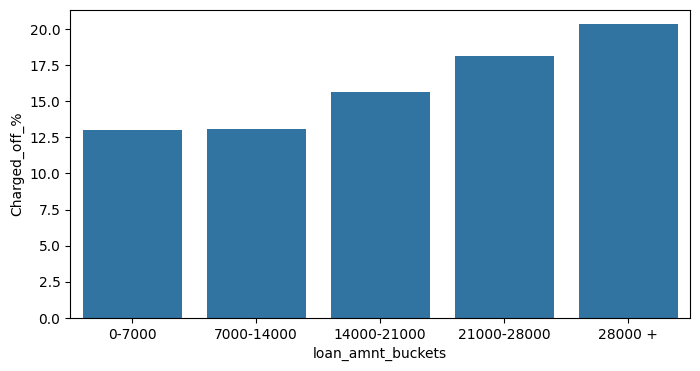

In [334]:
plt.figure(figsize=(8, 4))
sns.barplot(x='loan_amnt_buckets', y='Charged_off_%', data=loan_amount_vs_loan_status)
plt.show()

### Observation: Chance of Charged Off is getting increased with increase in loan amount 

### Bivariate Analysis between Purpose against Loan Status - Charged Off

In [335]:
purpose_vs_loan_status=pd.pivot_table(loan_data[['purpose','loan_status']],index='purpose',columns='loan_status',aggfunc=len).fillna(0).reset_index()

In [336]:
purpose_vs_loan_status['Total']=purpose_vs_loan_status['Charged Off']+purpose_vs_loan_status['Current']+purpose_vs_loan_status['Fully Paid']
purpose_vs_loan_status['Charged_off_%']=(purpose_vs_loan_status['Charged Off']/purpose_vs_loan_status['Total'])*100

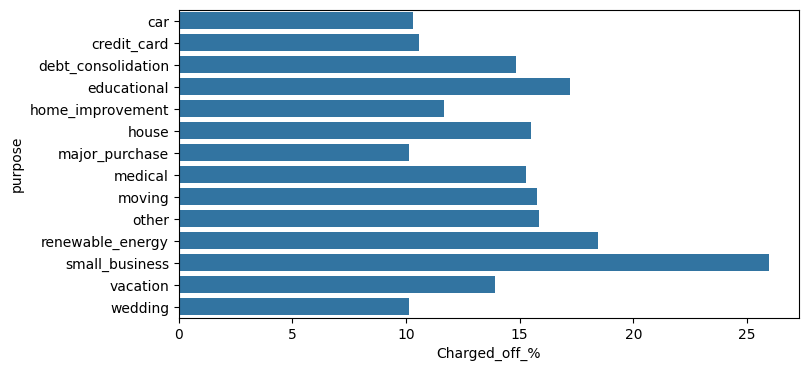

In [337]:
plt.figure(figsize=(8, 4))
sns.barplot(y='purpose', x='Charged_off_%', data=purpose_vs_loan_status)
plt.show()

### Observation: In the Univariate analysis, we found Most of the customers took loan for debt consolidation and credit card payment but from the above  Bivariate analysis, it is evident that customers who took loan for small business have a chance of getting charged off/

### Bivariate Analysis between Annual income against DTI

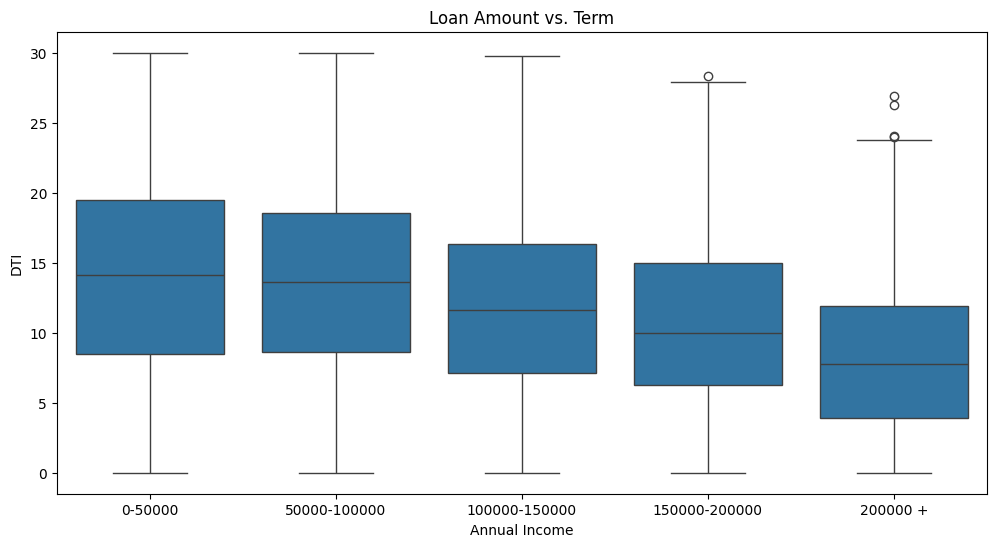

In [338]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='dti', x='annual_inc_buckets', data=loan_data)
plt.title('Loan Amount vs. Term')
plt.xlabel('Annual Income')
plt.ylabel('DTI')
plt.show()

### Observation: Debt to Income ratio is getting lower when Annual income is higher, Above analysis shows people with lower annual income is having high chance of getting defaulted

### Bivariate Analysis between Home Ownership against Loan Status

In [339]:
home_ownership_vs_loan_status=pd.pivot_table(loan_data[['home_ownership','loan_status']],index='home_ownership',columns='loan_status',aggfunc=len).fillna(0).reset_index()
home_ownership_vs_loan_status['Total']=home_ownership_vs_loan_status['Charged Off']+home_ownership_vs_loan_status['Current']+home_ownership_vs_loan_status['Fully Paid']
home_ownership_vs_loan_status['Charged_off_%']=(home_ownership_vs_loan_status['Charged Off']/home_ownership_vs_loan_status['Total'])*100

In [340]:
home_ownership_vs_loan_status

loan_status,home_ownership,Charged Off,Current,Fully Paid,Total,Charged_off_%
0,MORTGAGE,2327.0,638.0,14694.0,17659.0,13.177417
1,NONE,0.0,0.0,3.0,3.0,0.000000
2,OTHER,18.0,0.0,80.0,98.0,18.367347
3,OWN,443.0,83.0,2532.0,3058.0,14.486593
4,RENT,2839.0,419.0,15641.0,18899.0,15.021959


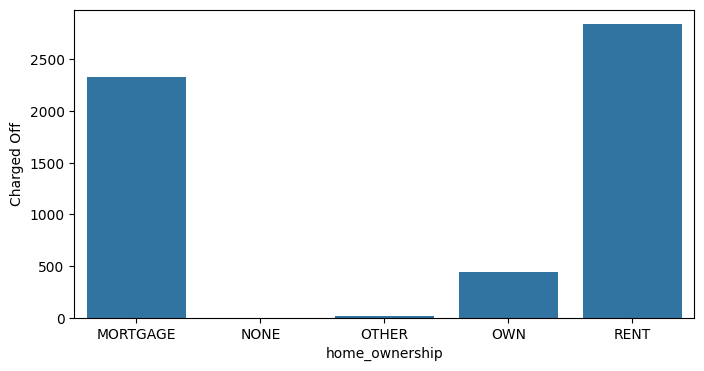

In [341]:
plt.figure(figsize=(8, 4))
sns.barplot(x='home_ownership', y='Charged Off', data=home_ownership_vs_loan_status)
plt.show()

### Observation: Those who have Home Ownership status as Rent and Mortgage have high chance of getting default

### Bivariate Analysis between Grade against Loan Amount

<Axes: xlabel='grade', ylabel='loan_amnt'>

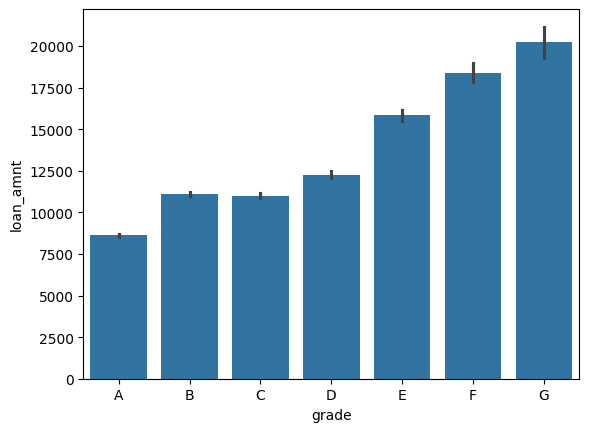

In [342]:
sns.barplot(x='grade', y='loan_amnt', data=loan_data,order = loan_data['grade'].sort_values())

In [343]:
emp_length_vs_loan_status=pd.pivot_table(loan_data[['emp_length','loan_status']],index='emp_length',columns='loan_status',aggfunc=len).fillna(0).reset_index()
emp_length_vs_loan_status['Total']=emp_length_vs_loan_status['Charged Off']+emp_length_vs_loan_status['Current']+emp_length_vs_loan_status['Fully Paid']
emp_length_vs_loan_status['Charged_off_%']=(emp_length_vs_loan_status['Charged Off']/emp_length_vs_loan_status['Total'])*100

In [344]:
emp_length_vs_loan_status

loan_status,emp_length,Charged Off,Current,Fully Paid,Total,Charged_off_%
0,0,228,42,805,1075,21.209302
1,1,1095,146,6582,7823,13.997188
2,2,567,97,3724,4388,12.921604
3,3,555,83,3457,4095,13.553114
4,4,462,94,2880,3436,13.445867
5,5,458,88,2736,3282,13.954906
6,6,307,61,1861,2229,13.772992
7,7,263,62,1448,1773,14.833615
8,8,203,44,1232,1479,13.725490
9,9,158,32,1068,1258,12.559618


<Axes: xlabel='emp_length', ylabel='Charged_off_%'>

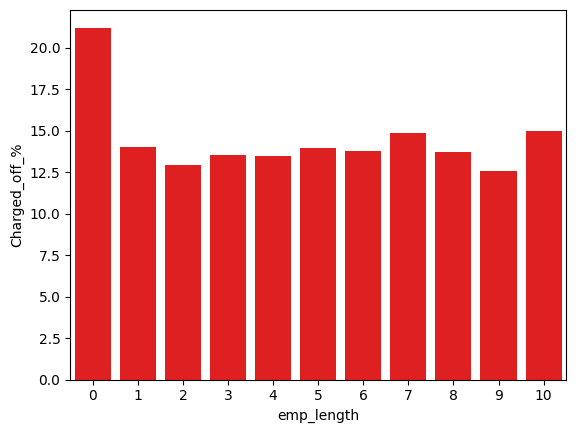

In [345]:
sns.barplot(x='emp_length',y='Charged_off_%', data=emp_length_vs_loan_status,color='red')

### Observation: High chance of Charged Off When employee has 0 or 1 years of experience. 

In [ ]:
loan_data.loan_amnt.astype('float')

In [ ]:
loan_data.dtypes

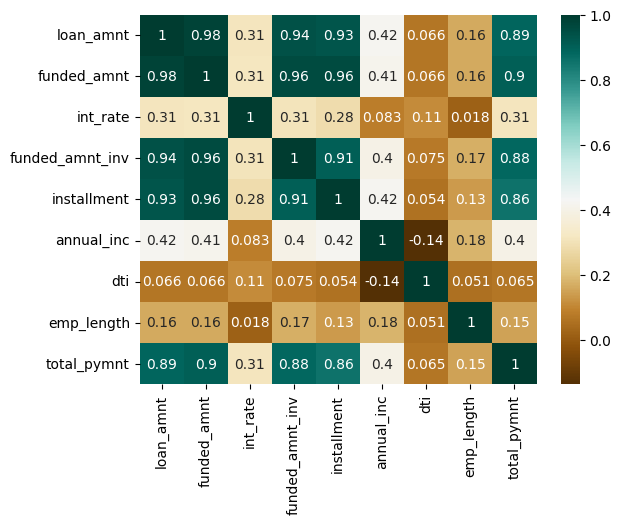

In [369]:
#Multi variate Analysis
loan_correlation=loan_data[amount_columns].corr()
sns.heatmap(loan_correlation,annot=True,cmap="BrBG")
plt.show()


### Observation:
#### 1. Loan Amount, Funded Amount, Funded Amount by investor, Installment and Total payment are highly correlated with each other. 
#### 2. Annual Income and Debt to Income Ratio are negatively correlated with each other. 
#### 3. This shows increase in Annual income will decrease the Debt to income ratio and vice versa 


In [381]:
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'revol_bal', 'revol_util', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies',
       'normalized_dti', 'normalized_loan_amnt', 'credit_score',
       'loan_utilization_rate', 'year', 'month', 'loan_amnt_buckets',
       'annual_inc_buckets', 'int_buckets', 'dti_buckets',
       'approval_percentage'],
      dtype='object')